<a href="https://colab.research.google.com/github/axellebersier/2022_ML_EES/blob/main/Exersises/S6_2_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Week 6 Exercise 2 – Recurrent Neural Networks for Hydrological Modeling**


<center><img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EX7p8EcOwelFg3UkF7576noBzjdubEy10lWXbULT_N6QHw?download=1' width=100%> <i>The rain fell alike upon the just and upon the unjust, and for nothing was there a why and a wherefore. - William Somerset Maugham</i> </center>
<br>

Rain is oft described as having a gloomy beauty to it, and it continues to inspire authors and scientists alike. Can we use machine learning algorithms to predict rainfall runoff with comparable accuracies to other established methods?

In [97]:
#@title  Run this cell for preliminary requirements. Double click it if you want to check out the source :)

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To make this notebook's output stable across runs
rnd_seed = 42
rnd_gen = np.random.default_rng(rnd_seed)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Import pooch - used to handle data downloading
import pooch

Welcome to the practical application notebook for this week, where we'll be using a Long-Short Term Memory (LSTM) neural network in order to model rainfall-runoff! Let's begin by loading in our data using pooch and pandas.

In [98]:
#@title Let's download the data onto the storage on the server using pooch. Remember you can check the source by double cliking on cells like these. 
data_url = 'https://unils-my.sharepoint.com/:x:/g/personal/tom_beucler_unil_ch/EQ0OKNafmxdJvXUMPfwGyecBwCPZJ1Y8_ATlmbrUFySkzw?download=1'
data_file = pooch.retrieve(data_url, known_hash='3b647bb9318865be5858bccd1539148fbc58f7425d09ac62d8e459682958940a');


###**Q1) Go ahead and load the csv file with the data for our project today. The filepath is stored in the `data_file` variable that was defined in the hidden code within the cell above this one!**

In [99]:
#@title Hints - Loading CSVs with Pandas

'''
Pandas has a handy .read_csv function!

There's an argument you can pass which will let you define the column to use as
an index. 

There's also a single argument which when set to true will make pandas try to
automatically parse fields it thinks are dates into datetime variables. This
will be usefull when we split the data!

''';
# Uncomment the line below and run this cell to open up the help dialog in colab
pd.read_csv??

# Uncomment the code below and run the cell to get a look at the data 
pd.read_csv(data_file).head()

,Unnamed: 0,T,P1,P2,runoff
0,1/1/1931,3.6,1.6,1.0,3.91
1,1/2/1931,3.6,2.8,3.8,4.01
2,1/3/1931,5.4,0.0,0.1,3.91
3,1/4/1931,3.9,13.1,10.8,4.92
4,1/5/1931,0.5,0.0,0.0,4.67


In [100]:
# Let's load the CSV file into the "data" variable
data = pd.read_csv(data_file, # Path to the CSV
                       index_col = [0], # Define the date column as the index. 
                       parse_dates = [0], # Tell pandas to parse the date index.
                       )
# Print the first 5 rows of data to see if we've loaded it correctly! 
data.head()


,T,P1,P2,runoff
1931-01-01,3.6,1.6,1.0,3.91
1931-01-02,3.6,2.8,3.8,4.01
1931-01-03,5.4,0.0,0.1,3.91
1931-01-04,3.9,13.1,10.8,4.92
1931-01-05,0.5,0.0,0.0,4.67


We now have our data in a nice format for us to use. You'll see that our data has an index column, a T column, a P1 column, a P2 column, and a runoff column. The index column is the date of our measurements, the T column is the mean daily temperature at a station, the P1 and P2 columns are the daily precipitations at two stations, and the runoff column is the daily streamflow at one station.

 Let's go ahead and figure out how many years of data we have by looking at the time index.

###**Q2) Store the list of available years of data in a variable, and print out the length of the list.**

In [101]:
#@title Hint: How to use Pandas datetimeIndex
'''
When loading the data, we used the date column as the index - this means that 
we can access the date using the .index attribute of the dataframe.
e.g.: for the df dataframe, df.index will return the index column

Additionally, we set parse_dates to True, so the dates were transformed from
a simple test representation of the date to a more powerfull pandas datetime
format. Here, we can directly access key parts of the date
e.g.: df.index.month will retrieve the month for each row index.

This can be useful for verifying or selected seasonal data, such as
for winter (december-january-february, or djf). Using built-in pandas functions
to find the unique values in the index.month column would let us
verify that all relevant month values are present (i.e., 1, 2, 12)
''';

In [102]:
years_available = data.index.year.unique() 
print(years_available)   

Int64Index([1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
            1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
            1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
            1964, 1965, 1966, 1967, 1968, 1969, 1970],
           dtype='int64')


Now we need to split the dataset into a training, validation, and test set to use with our algorithm. Since we're dealing with time series data, let's use the last 10 of the years available as the test dataset, the 10 years previous to that as the validation dataset, and the remainder of the data will be used to train our algorithm.

###**Q3) Split the dataset into a training, validation, and test set.**

In [103]:
#@title Hint: Review of array slicing
'''
You can select data in an array/DataFrame using an index within square brackets
data[num_index] will return the value of data at the nth num_index entry. This
also works with negative numbers, which are used to count from the end of the 
array.
e.g., if we define myArray = [0 1 2 3 4 5 6 7 8 9]
myArray[0] will return 0, myArray[1] will return 1
myArray[-1] will return 9, myArray[-2] will return 8

We can also select multiple values of the array using colons. Remember that
indices use the [start:end:step] convention
myArray [4:] will return [4, 5, 6, 7, 8, 9]
myArray [:4] will return [0, 1, 2, 3]
myArray [2:5] will return [2,3,4]
myArray [-3:] will return [7, 8, 9]
myArray [-5:-2] will return [5, 6, 7]
myArray [2:-2] will return [2, 3, 4, 5, 6, 7]

Stepping
myArray [::2] will return [0, 2, 4, 6, 8]
myArray [-4::2] will return [6, 8]
myArray [2:-2:2] will return [2, 4, 6]
''';

In [104]:
#@title Hint: Finding/Selecting data in a Pandas dataframe
'''
Pandas dataframes have useful functions that allow you to filter values.
One way to filter for specific time values is to rely on the `isin()` method
of datasets. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isin.html

For example, if we were trying to take a dataset covering every month of the
year and we're only interested in the winter season (DJF), we could use:
boolean_index = df.index.month.isin([12,1,2])
This would return a boolean index that you can use to select the relevant rows
from the dataframe.

In order to select the relevant datapoints, you can rely on the .loc method: 
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html
Using this method, you could select the data as follows:
relevant_datapoints = df.loc[boolean_index]

If you want to select every month that is _not_ in winter, you would instead
write: 
relevant_datapoints = df.loc[~boolean_index]
Since ~ is the bitwise negation operator, it effectively "nots" boolean arrays
''';

In [105]:
#Select the last ten years for your test set
test_years = years_available[30:]

In [106]:
# Select ten years at random from the remaining set
validation_years = years_available[20:30]

In [107]:
# define the test set: test_set
test_set = data.loc[data.index.year.isin(test_years)]

In [108]:
# define the validation set: val_set
val_set = data.loc[data.index.year.isin(validation_years)]

In [109]:
# define the training set: train_set
# Note that the '~' translates to "not" - this allows us to find the training 
# years by specifying it's those not in the list of test_years and validation_years
train_set = data.loc[~data.index.year.isin([*test_years,*validation_years])]

The data we're using today has already been cleaned up - we know it doesn't have any NaN values. 

Still, it's good practire to check! Do so in the cell below.

In [110]:
# Since booleans are interpreted as 0 or 1 when doing math, we can use the
# isna() method in pandas dataframes and sum the result to check how many NaN
# values are in the dataset. We should get 0 today!
test_set.isna().sum()

T         0
P1        0
P2        0
runoff    0
dtype: int64

In [111]:
# Print out the first five rows of each dataset.
# Make sure that your split matches ours!
print(train_set.head(), val_set.head(), test_set.head(), sep='\n\n')

              T    P1    P2  runoff
1931-01-01  3.6   1.6   1.0    3.91
1931-01-02  3.6   2.8   3.8    4.01
1931-01-03  5.4   0.0   0.1    3.91
1931-01-04  3.9  13.1  10.8    4.92
1931-01-05  0.5   0.0   0.0    4.67

              T   P1   P2  runoff
1951-01-01 -0.9  0.0  0.0    3.22
1951-01-02  0.7  2.6  3.0    3.12
1951-01-03 -1.2  5.8  0.0    3.12
1951-01-04 -1.8  0.0  0.0    2.93
1951-01-05 -0.6  0.0  0.0    2.84

              T    P1    P2  runoff
1961-01-01  1.0   6.0   7.4     3.6
1961-01-02  0.4   0.2   0.0     3.4
1961-01-03  2.7  13.7  12.2     3.5
1961-01-04  0.3   0.5   2.4     3.4
1961-01-05 -0.4   0.3   0.5     3.4


You should now have your dataset split up as three pandas dataframes. If you print out the first five rows of each dataset, you should get the following:

<center><img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EUmui9FDDxxFpxjrY4I7MMABit-4pVJziPGmCZqMMwU28w?download=1'></center>

We now have our data for training, validating, and testing our algorithm! However, the values are still the original ones from our measurements. We saw before that we generally want to transform these into stardardized values, otherwise we might end up with a _problem of scales._

<center> <img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EQEslPIi1XZCgYGqSst2AOsBbZ5NHo7tpj1bFpW8Krzqgg?download=1' width=75%><br><font size=5><i>get it?</i></font></center>

With that joke out of our system, let's go ahead and prepare a Scikit-Learn pipeline to scale our data.

###**Q4) Scale the input data using a StandardScaler (i.e., using the mean and standard deviation).**

In [112]:
#@title Hint: Review of Scikit Learn pipelines and transformers
'''
Scikit include several tools to preprocess data, ranging from utilities for
imputation to utilities for scaling data.

The column transformer will allow us to apply specific transformers to columns
in the pandas dataframe. We also can specify what to do with the 
columns to which we don't want to apply transformations. You can check the
documentation at the link below:
https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

For example, take a dataframe including the temperature T, sea level pressure
SST, relative humidity RH, mean sea level pressure MSLP, and surface pressure SP

We want to train a model that takes T, SST, RH, and MSLP to make a weather 
prediction, and want the variables to be scaled to fit strictly between 0 and 1.
Rather than code a script for this, a Column Transformer can be defined that
uses remained='drop' as a parameter (thereby dropping SP), and a MinMaxScaler 
function for the transformer.

The code would look something like:
preprocesser = ColumnTransformer(
                           remainder='drop', 
                           transformers=[
                              ('scaling', MinMaxScaler(), ('T', 'SST', 'RH', 'MSLP')),
                           ])

The column transformer serves two functions: fitting and transforming
When fitting, the transformer takes the input data and figures out how it will
transform data later. In the example above, this would include calculating the
minimum and maximum value for each column.

Transforming takes the fitted transformer and calculates the new values of the
column, as well as performing any other operations on the data (e.g., dropping
the SP variable).

Generally, you want to fit the transformer using the training data, and then
transform the training data, the validation data, and the test data. We avoid
fitting to the validation and test data.

Additionally, though transformer.fit() and transformer.transform() exist
individually, fitting to and transforming the training data is so common that
a combined method is implemented in sklearn: fit_transform()

Today, you should use the StandardScaler in order to process your numerical
data. You can find more infomation about StandardScaler in the 
''';

In [113]:
# Import the parts of Scikit Learn we need for scaling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [114]:
# Create a Column Transformer
scaler = ColumnTransformer(
                           remainder='drop', # We leave the non-input columns alone
                           transformers=[
                              ('scaling', StandardScaler(), ('T', 'P1', 'P2', 'runoff')),
                           ]) #Define the scaler to use and which columns to use it on

In [115]:
train = scaler.fit_transform(train_set) # fit the scaler and transform the train_set
val = scaler.fit_transform(val_set) # transform the val_set
test = scaler.fit_transform(test_set) # transform the test_set


If you did everything right, the first two rows of your dataset should return:

Training: \
`[[-0.67248997 -0.24609328 -0.32674546  3.91      ]`\
` [-0.67248997 -0.07489897  0.08869363  4.01      ]]`

Validation: \
`[[-1.28097285 -0.47435235 -0.47511657  3.22      ]`\
`[-1.06462338 -0.10343136 -0.03000326  3.12      ]]`

Test:\
`[[-1.02405785  0.38161917  0.6228296   3.6       ]`\
`[-1.1051889  -0.44581996 -0.47511657  3.4       ]]`

In [116]:
# Make sure your datasets have been scaled correctly
print(train[:2], val[:2],test[:2], sep='\n\n')

[[-0.67248997 -0.24609328 -0.32674546 -0.85064161]
 [-0.67248997 -0.07489897  0.08869363 -0.84485279]]

[[-1.30330564 -0.50264551 -0.49751644 -0.92761152]
 [-1.08040831 -0.12954935 -0.03423757 -0.93353917]]

[[-0.96212053  0.37903176  0.65490617 -0.84517109]
 [-1.04236591 -0.47387526 -0.49188829 -0.85661086]]


We're almost ready to start training our algorithm! However, we currently have a list of temperature, precipitation, and runoff readings _for each day_ in our datasets. However, we're interested in looking at an $n$-sized __window__ of temperature and precipitation readings to predict a point in the runoff series! 

As an example with $ n= 5$: $\;$
to predict the runoff on a given Friday, we need the temperature and precipitation readings for Monday, Tuesday, Wednesday, Thursday, and the Friday itself.

###**Q5) Turn the training, validation, and test data into a set of series to feed into an LSTM**

In [117]:
# Let's start by printing out the shape of our training dataset
print(train.shape)

(7305, 4)


In [118]:
# Sequence length will determine how many days we will take into consideration
# when trying to predict the runoff. You can try multiple values, and we 
# recommend you check out the results for n= [7, 30, 182, 365]
sequence_length = [7, 30, 182, 365]

In [119]:
# In order to get the windows for the input data, we'll rely on numpy's 
# sliding window view. You can check the documentation for
# numpy.lib.stride_tricks.sliding_window_view for more information
# https://numpy.org/devdocs/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html

window_size = 10


# For the source array, since we're saving X, we just need the columns for T,
# P1, and P2. We don't want to include the runoff!
train_X = np.lib.stride_tricks.sliding_window_view(train[:,:3], # source array
                                                   window_size, # window size 
                                                   axis=0) # Window Sliding Direction

val_X = np.lib.stride_tricks.sliding_window_view(val[:,:3], # source array
                                                 window_size, # window size 
                                                 axis=0) # Window Sliding Direction

test_X = np.lib.stride_tricks.sliding_window_view(test[:,:3], # source array
                                                  window_size, # window size 
                                                  axis=0) # Window Sliding Direction

Let's try printing out the shape of a trasnformed dataset...

In [120]:
print(train_X.shape)

(7296, 3, 10)


You should find that the dataset has the wrong shape for our purposes! The sliding_window_view function will have returned the data in the shape:\
(number of samples, **number_of_features**, sequence_length) 


However, the convention we've followed so far in our course (which is quite common in the field) is features last: \
(number of samples, sequence_length, **number_of_features**).

We can fix this with `numpy.moveaxis()`!

In [121]:
train_X = np.moveaxis(train_X, # source array
                      1, # axis to move 
                      2) # destination for the axis

val_X = np.moveaxis(val_X, # source array
                    1, # axis to move 
                    2) # destination for the axis

test_X = np.moveaxis(test_X, # source array
                     1, # axis to move 
                     2) # destination for the axis
     

We now need to prepare the target data using the runoff column! \
Here, we just need to select the column, skipping over the first ($window\_size - 1$) elements.

In [122]:
# For each set, take the data between the window_size-1th element and the last element
train_y = train[window_size-1:,-1]  
val_y = val[window_size-1:,-1]
test_y = test[window_size-1:,-1]

Let's check the shape of our arrays to make sure that things make sense!

In [123]:
print(f'Train Shape:      X:{train_X.shape}, y:{train_y.shape}',
      f'Validation Shape: X:{val_X.shape}, y:{val_y.shape}',
      f'Test Shape:       X:{test_X.shape}, y:{test_y.shape}', sep='\n')

Train Shape:      X:(7296, 10, 3), y:(7296,)
Validation Shape: X:(3644, 10, 3), y:(3644,)
Test Shape:       X:(3643, 10, 3), y:(3643,)


During development, a window size of 365 days was used. With this window size, the shape of our input/output datasets are: \
`Train Shape:      X:(6941, 365, 3), y:(6941,)` \
`Validation Shape: X:(3289, 365, 3), y:(3289,)` \
`Test Shape:       X:(3288, 365, 3), y:(3288,)`

We finally have a dataset that we can easily use to train an LSTM! From this point on, we'll be relying on [PyTorch](https://pytorch.org/) to get our model ready.

Let's start by importing the parts that we'll need. We won't hide any of the code here so you can see everything that's being done _without_ extra clicking. \
<center><font size=30>😀</font></center>

In [124]:
# Let's import the main PyTorch library
import torch

# Let's import the pytorch nn module, which gives us access to a simpler API for 
# defining our model  (It includes layer abstractions and other nifty tools)
import torch.nn as nn

# And import utilities to help us easily handle batch sizing
from torch.utils.data import DataLoader, TensorDataset

In [125]:
#@title Run this cell to check if a GPU is available. We'll use a variable called `calc_device` to store either the cpu or gpu to run calculations on. 
if torch.cuda.device_count()>0:
  calc_device = torch.device('cuda:0')
else:
  calc_device = torch.device('cpu')

First, let's start by moving away from Pandas Dataframes and NumPy N-Dimensional Arrays and into the realm of PyTorch _Tensors_. 

### **Q6) Convert the prepared datasets into PyTorch Datasets**

In [126]:
#@title Hint: Transitioning from Numpy ND-Arrays to Pytorch Tensors
'''
Pytorch includes utilities to change from numpy arrays to tensors. These include
torch.from_numpy(DATA_SOURCE) and torch.FloatTensor(DATA_SOURCE). We recommend
that you use FloatTensor, as its the default precision in PyTorch at the time of
writing. 

Using from_numpy will default to double precision using our scripts so
far, and will raise an exception later unless you change everything to double
precision.

the .to() method sends the tensor to a device. Importantly, all tensors
should be on the same device. (Trying to do things across devices is very fancy
and is therefore outside the scope of the course!)
''';

In [127]:
#@title Hint: Datasets from Tensors
'''
You can make a dataset by calling 
torch.TensorDataset(input_tensor, output_tensor)

This creates an subscriptable iterator (i.e., you can use an [index] to access 
the index-th pair of input-output data)

Using this abstraction ensures that your input and output tensors have the same
size! It's a good sanity check.
''';
#TensorDataset?

In [128]:
# Let's convert our numpy arrays into tensors
train_Xtensor = torch.FloatTensor(train_X).to(calc_device)
train_ytensor = torch.FloatTensor(train_y).to(calc_device)

val_Xtensor = torch.FloatTensor(val_X).to(calc_device)
val_ytensor = torch.FloatTensor(val_y).to(calc_device)

test_Xtensor = torch.FloatTensor(test_X).to(calc_device)
test_ytensor = torch.FloatTensor(test_y).to(calc_device)

In [129]:
# And group them into a dataset using the TensorDataset utility
train_data = TensorDataset(train_Xtensor, train_ytensor)
val_data = TensorDataset(val_Xtensor, val_ytensor)
test_data = TensorDataset(test_Xtensor, test_ytensor)

Let's check that your tensors and datasets have been converted properly. Run the code below and compare it to our results (remember, we used 365 days as the window_size and a batch size of 128 - if your hyperparameters are different your numbers will be different)

In [130]:
print(f'X tensor size (train): {train_Xtensor.size()}',
      f'X tensor size (val): {train_Xtensor.size()}',
      f'X tensor size (test): {train_Xtensor.size()}\n',
      f'Train dataset size =: {len(train_data)}',
      f'Validation dataset size =: {len(val_data)}',
      f'Test dataset size =: {len(test_data)}',
      sep='\n')

X tensor size (train): torch.Size([7296, 10, 3])
X tensor size (val): torch.Size([7296, 10, 3])
X tensor size (test): torch.Size([7296, 10, 3])

Train dataset size =: 7296
Validation dataset size =: 3644
Test dataset size =: 3643


During development, the output of the cell above was: \
`X tensor size (train): torch.Size([6941, 365, 3])` \
`X tensor size (val): torch.Size([6941, 365, 3])` \
`X tensor size (test): torch.Size([6941, 365, 3])` \

`Train dataset size =: 6941` \
`Validation dataset size =: 3289` \
`Test dataset size =: 3288` \

Now that we have our datasets as PyTorch tensors, we can go ahead and load them into a $\color{Green}{\textit{DataLoader}}$. 

In PyTorch, DataLoaders are an abstraction that let's you do many powerful things to a dataset, such as: getting samples, shuffling, and other operations that are outside of the scope of this lab / course.

Before we make the DataLoaders, we need to define some hyperparameters for our training. Specifically, we want to define the __batch size__ \(i.e., how many sample you train on at a time). We also need to define a setting: the number of workers we'll use.

We recommend you use a batch size of 128, and two workers. We won't go into details on how large a batch size to use, especially as there is ongoing research on the topic (e.g., [in](https://arxiv.org/abs/1609.04836) [these](https://arxiv.org/abs/2006.08517) [papers](https://arxiv.org/abs/1711.00489)). However, too large a batch size tends to make it harder for ML algorithms to generalize. As for the number of workers, this is generally dictaded by how many cpu/gpu cores you have available.

### **Q7) Define the hyperparameters and settings for training**

In [131]:
#Define the hyperparameters
batch_size = 128
num_workers = 2

### **Q8) Define the training, validation, and test Dataloaders**

In [132]:
#@title Hint: PyTorch DataLoaders
'''
PyTorch Dataloaders
Now that you have a pytorch dataset, you can feed it into a dataloader.
Dataloaders can handle shuffling (important during training! Not so much
for validation and testing...), and will automatically cut the data into
batches if the batch_size parameter is given.

Our data is small this time, so this isn't strictly necessary. But it's good
practice.
''';
#DataLoader?

In [133]:
train_loader = DataLoader(
    dataset = train_data, # Define the dataset to use
    batch_size = batch_size, # Set the batch size
    shuffle = True# Define if shuffling is necessary for this loader
)

val_loader = DataLoader(
    dataset = val_data, # Define the dataset to use
    batch_size = batch_size, # Set the batch size
    shuffle = True # Define if shuffling is necessary for this loader
)

test_loader = DataLoader(
    dataset = test_data, # Define the dataset to use
    batch_size = batch_size, # Set the batch size
    shuffle = True # Define if shuffling is necessary for this loader
)

We're now fully ready on the data side - let's go on to setting up the neural network.

When we were using Tensorflow, we defined a neural network by defining an instance of `tensorflow.keras.Model()`. Now that we're using pytorch, we'll instead _extend_ the equivalent of the model class in PyTorch - the `nn.Module` class. You can read more about the class in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) online.

Whenever we want to design a model with an LSTM layer, we'll need to define how many LSTM units we want to use (this will be the first hyperparameter for our simple LSTM model).

We'll also be adding a dropout layer to our simple LSTM architecture. That is, there will be a fixed chance that the output of each LSTM unit will be zeroed during training - this will make our model more robust. Also, the probability of zeroing an output will be another hyperparameter.

Finally, the last state of the LSTM layer are going to be combined linearly into a prediction for the runoff at the end of the time series. The default notebook will use a simple linear combination (i.e., we won't be using an activation function on the combination the way we often did before).

### **Q9) Define the LSTM model architecture**

In [134]:
#@title Hints

#nn.Module?
#nn.LSTM?
#nn.Dropout?
#nn.Linear?

In [135]:
# We'll start by defining a class extension:

class MyLSTM(nn.Module): # Define the class which we're extending using our MyLSTM class
    # Begin by defining the initialization function for our class
    def __init__(self, # The first argument to the class in all methods is itself 
                n_units, # Model Hyperparameter 1
                prob_zero): # ModelHyperparameter 2
        
        #To make sure our class initializes properly, we'll call its superclass
        # (i.e., the class it's based off of) and run its 
        super(MyLSTM, self).__init__()

        # Store the hyperparameters passed into the class during initialization
        self.n_units = n_units
        self.prob_zero = prob_zero

        # Define the LSTM layer
        self.LSTM_layer = nn.LSTM( # Let's instantiate the pytorch LSTM module 
            input_size = 3, # The number of features in the input series
            hidden_size = self.n_units, # The number of LSTM cells per layer
            num_layers = 1, # The number of LSTM Layers
            bias = True, # Enable the use of biases
            batch_first = True # Let the layer know the input shape is (batch_size, series_len, num_features) 
        )

        # Define the Dropout Layer
        self.dropout_layer = nn.Dropout( #Instantiate the pytorch dropout layer
            p = self.prob_zero # Set the dropout rate
        )

        # Define the the output layer - we'll make a linear aggregation of the LSTM outputs 
        self.out_layer = nn.Linear( #Instantiate the pytorch linear layer
            in_features = self.n_units, # Number of inputs
            out_features = 1 # Number of predictions per number of inputs
        )
        # Define the forward pass
    def forward(self, X):

        # Calculate the LSTM output, hidden state, and memory cell
        # Note that output is not our model's output!
        # Read the documentation here: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        output, (h_n, c_n)  = self.LSTM_layer(X)

        # Calculate our model's hidden state from the last hidden state of the LSTM
        hiddenstate = self.dropout_layer(h_n[0])

        # Make the prediction by using the relu( dense ( hidden_state ) )
        phat = torch.flatten(torch.relu(self.out_layer(hiddenstate)))
        return phat
     

Now that we have the model defined, we'll also be using a metric of performance that is somewhat more uncommon in machine learning applications than in hydrology - the **Nash-Sutcliff-Efficiency (NSE) Coefficient**. You can read more about it [on Wikipedia](https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient).

In [136]:
#@title Run this cell to define the NSE calculation function. It will be accessible as `calc_NSE`

# Customzied evaluation metric NSE for validation set and test set # 
def calc_nse(sim: torch.FloatTensor, obs: torch.FloatTensor, global_obs_mean: torch.FloatTensor) -> float:
    """Calculate the Nash-Sutcliff-Efficiency coefficient.

    :param obs: Array containing the observations
    :param sim: Array containing the simulations
    :param global_obs_mean: mean of the whole observation series
    :return: NSE value.
    """
    numerator = torch.square(sim - obs).sum()
    denominator = torch.square(obs - global_obs_mean).sum()
    nse_val = 1 - numerator / denominator

    return nse_val

The next thing we need to think about is the hyperparameters for our model and training. More specifically, we need to choose:
* a number of LSTM units
* the dropout rate 
* define our loss function
* choose our optimizer and its parameters. 
* define the number of epochs we will train for

Thankfully, it's not our first rodeo! \
<center><font size=30>🤠</font></center>

Regarding the number of units, we chose 16 units during development of the notebook. Feel free to change this, e.g. to values between 1 and 128.

The dropout rate is the probability that an LSTM unit will be zeroed. We'll set it to 0.125 (i.e., 1/8), which means we expect to drop the output from ~two of the LSTM cells at random. You can read more [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

Since this is a regression problem, we'll rely on MSE as the loss function.

We've also know that Adam is a reliable optimizer, so we'll go ahead and use that. Adam needs us to define a learning rate, and $1*10^{-3}$ is a common default value. We'll try it out to see if it's appropriate.  

 Note that you're free to play around with these hyperparameters - your performance will just be different from the ones we will show if you do so. I'm sure you can find a better solution 😀

### **Q10) Define the loss function, instantiate the model, define the optimizer, and set the number of epochs to iterate through**

In [137]:
# Define the loss function for training 
loss_func = nn.MSELoss()

# Instantiate our LSTM model
model = MyLSTM(n_units=16, # Hyperparameter 1
               prob_zero=0.125, # Hyperparameter 2
               ).to(calc_device) # Make sure the model is on the same device as the Tensors 

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), # We need to pass the parameters the optimizer will optimize
                             lr=0.003) # and pass the learning rate for the optimizer

# Define the number of epochs
num_epochs = 42
     
     

We're almost ready to train our model. Before we move on to the training routine, let's take a minute to define how we will evaluate the performance of the model - both for validation during training and for testing after training! 

### **Q11) Define the model evaluation function**

In [138]:
def eval_model(model, # the model to be evaluated
               val_loader, # the dataloader for the dataset used for the evaluation
               loss_func, # the main loss function to be used 
               calc_nse): # the function to be used as a performance metric
    # Tell pytorch that we don't need to keep track of the gradients
    # After all, gradients are only used during training.

    with torch.no_grad():       
        
        #Zero the loss and the metric
        loss = 0
        metric = 0

        # We'll start by calculating the mean of the whole dataset
        # This will be used in the NSE coefficient calculation
        
        # Start by defining a placeholder variable for the sum of the 
        # observations, and another for the number of datapoints in the set
        global_sum = 0
        label_size = 0

        # Iterate through the features and labels in the dataloader
        for features, labels in val_loader:
            # add the sum of the labels to the global sum
            global_sum += labels.sum()

            # Keep track of how many labels we've seen
            label_size += len(labels) 
        
        # Calculate the mean of the observations using the information gathered
        global_mean = global_sum/label_size

        # Iterate through the features and labels in the dataloader, this time
        # for evaluating the model
        for features, labels in val_loader:
            # get predictions from the model using the features in the batch
            pred = model(features)

            # calculate the batch loss
            batch_loss = loss_func(pred, labels)

            #calculate the batch metric
            batch_metric = calc_nse(pred, labels, global_mean)

            # Keep track of the loss and metric. Remember to convert them from 
            # pytorch tensors to scalars
            loss += batch_loss.item()
            metric += batch_metric.item()
        
        # Calculate the number of batches in the dataloader
        num_batches = len(val_loader)

        # Calculate the mean loss
        loss = loss/num_batches
        metric = metric/num_batches
        
        return (loss, metric)
     

With PyTorch, unlike with Keras, we need to write out the training and evaluation routines! We'll do this by using a nested for loops - the outer loop will run for the number of epochs, while the inner loops will iterate over the batches to train and validate the model. 

The outer loop will do the following:
  
* Set the training loss to zero 
* Train the model 
* Get the validation loss and metrics using our evaluation function
* Store the training and validation metrics



### **Q12) Write the training loop**

In [139]:
# Define empty lists that will be used to keep track of the training losses,
# validation losses, and validation metrics  
train_losses =[]
val_losses =[]
val_NSEs =[]

#
for epoch in range(num_epochs):
    # Zero the training loss
    train_loss = 0

    # Iterate through the features and labels in the train dataloader 
    for features, labels in train_loader:
        # We need to zero the gradients associated with the model parameters.
        # We can do this directly using the optimizer
        optimizer.zero_grad()

        # Get predictions from the features using the model
        pred = model(features)

        # And use the predictions to calculate the batch loss
        batch_loss = loss_func(pred, labels)

        # Do the backprogragation from the batch_loss
        batch_loss.backward()

        # Step through the optimizer
        optimizer.step()

        # Keep track of the train loss sum. 
        # Remember to turn the tensor into a scalar!
        train_loss += batch_loss.item()

    # Calculate the number of batches in the training dataloader
    num_batches = len(train_loader)


    # Get the mean training loss over the batches
    train_loss_mean = train_loss/num_batches

    # And append it into the list we defined to keep track of the loss
    train_losses.append(train_loss_mean)
    
    # Calculate the validation loss and metric.
    # Use the function we defined before!
    val_loss, val_NSE = eval_model(model, # The model
                                val_loader, # The dataloader
                                loss_func, # The loss function
                                calc_nse) # The metric function

    # Append the metric and loss values into the lists we made to keep track
    val_losses.append(val_loss)
    val_NSEs.append(val_NSE)

    # We want to save the model if it's the best version of it we've found
    # during training. If the NSE coefficient is the maximum in our training 
    # history, we'll go ahead and save the model as our best model.
    if val_NSE >= max(val_NSEs):
      torch.save(model, './best_model.pt')

    # And print out a statement to keep track of our training as we iterate
    print(f'\rEpoch: {epoch+1}/{epoch},' # Current epoch, total number of epochs
          f'train_loss: {train_loss},' # training loss we found this epoch
          f'val_loss: {val_loss},' # validation loss we found this epoch
          f'NSE: {val_NSE}', # NSE coefficient we found this epoch
          end="")
 

Epoch: 42/41,train_loss: 23.565406650304794,val_loss: 0.43185405279028005,NSE: 0.5579149496966395

In [140]:
#@title Run this cell to load the best model from our training before we evaluate the performance.
model = torch.load( './best_model.pt')

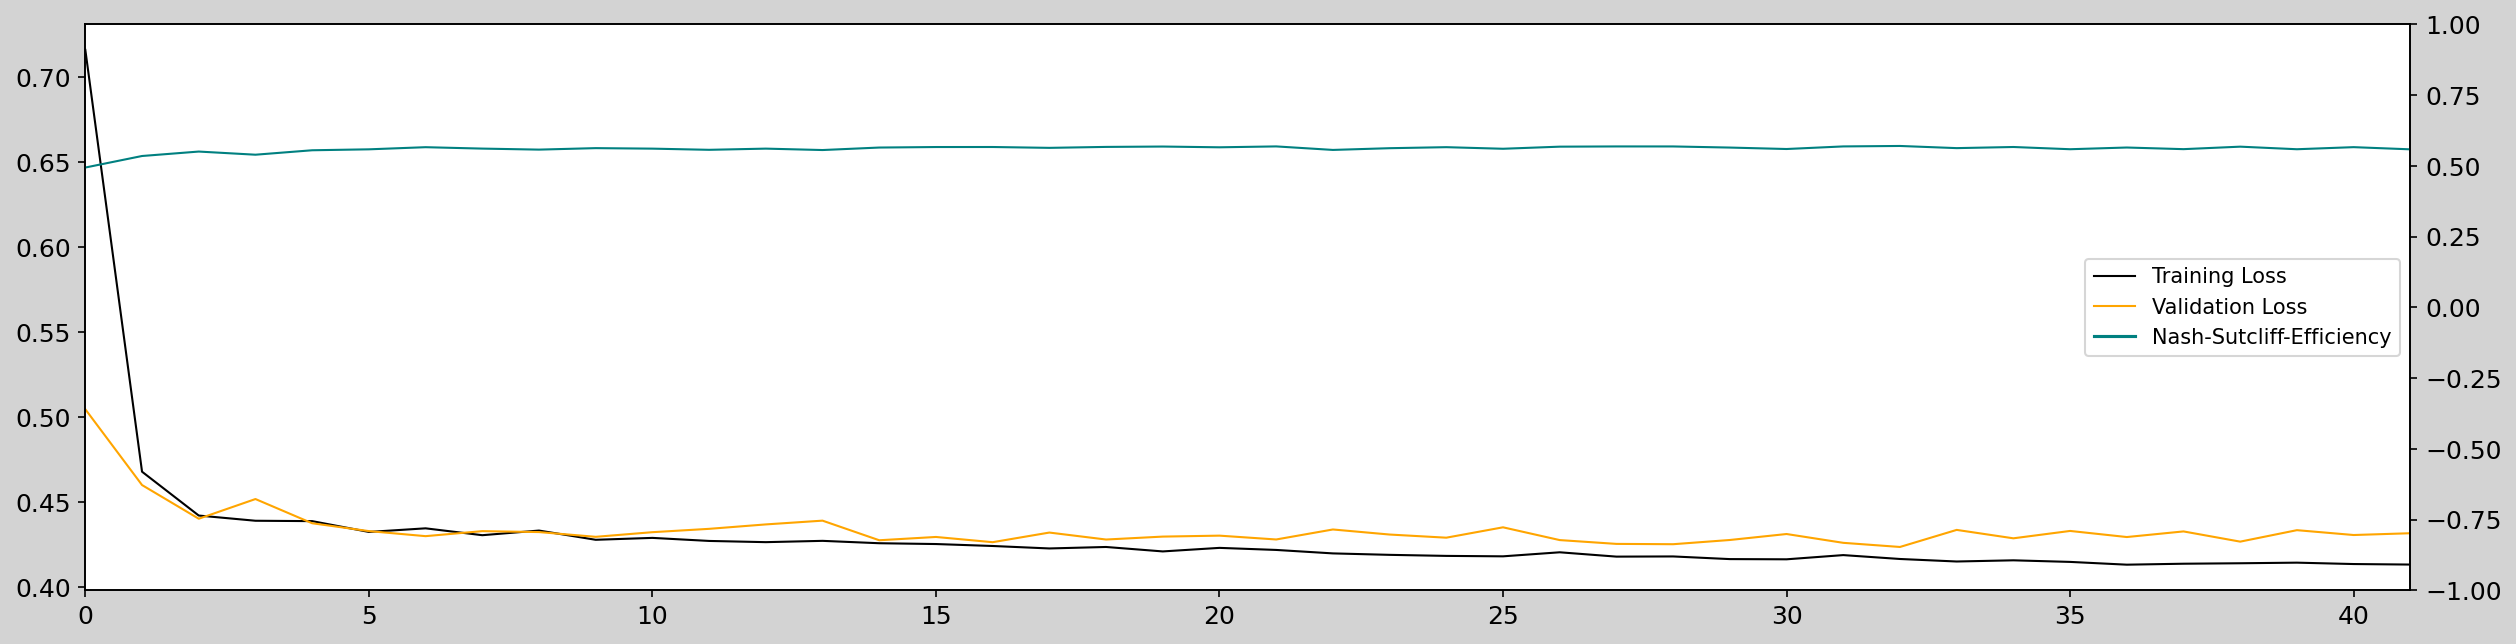

In [141]:
# Plotting out the Training and Validation performance. We'll use 
# torch.no_grad() since we don't need to calculate the gradients for
# plotting
with torch.no_grad():
    fig, ax = plt.subplots(figsize = (20,5), dpi=150)
    
    # Plot the training losses
    ax.plot(train_losses,
            c='black', 
            linewidth=1,
            label='Training Loss')
    
    # Plot the validation losses
    ax.plot(val_losses,
            c='orange', 
            linewidth=1,
            label='Validation Loss')
    
    # Empty NSE plot, used for easy legend generation
    ax.plot([],
            color='teal',
            label='Nash-Sutcliff-Efficiency')
    
    # Copy
    metric_ax = ax.twinx()
    metric_ax.plot(val_NSEs,
            c='teal', 
            linewidth=1,
            label='Nash-Sutcliff-Efficiency')
    metric_ax.set_ylim([-1,1])
    metric_ax.set_yticks(np.arange(-1,1.01,0.25))
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.legend(loc='center right')
    fig.set_facecolor('lightgrey')  

If you did everything the exact same way we did during development of the notebook (i.e., you chose the same hyperparameters as us) you should$^*$ get a set of training curves that look just like the ones below:
<center><img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EV_Tbnodg1VEkMbDkk8eRYgBE0KAl9KgnIYLKxLtb0lTog?download=1' width=100%>

$_{^{*}\text{GPU calculations are often non-deterministic for performance reasons, so you should get something remarkably similar, though not quite the same}}$

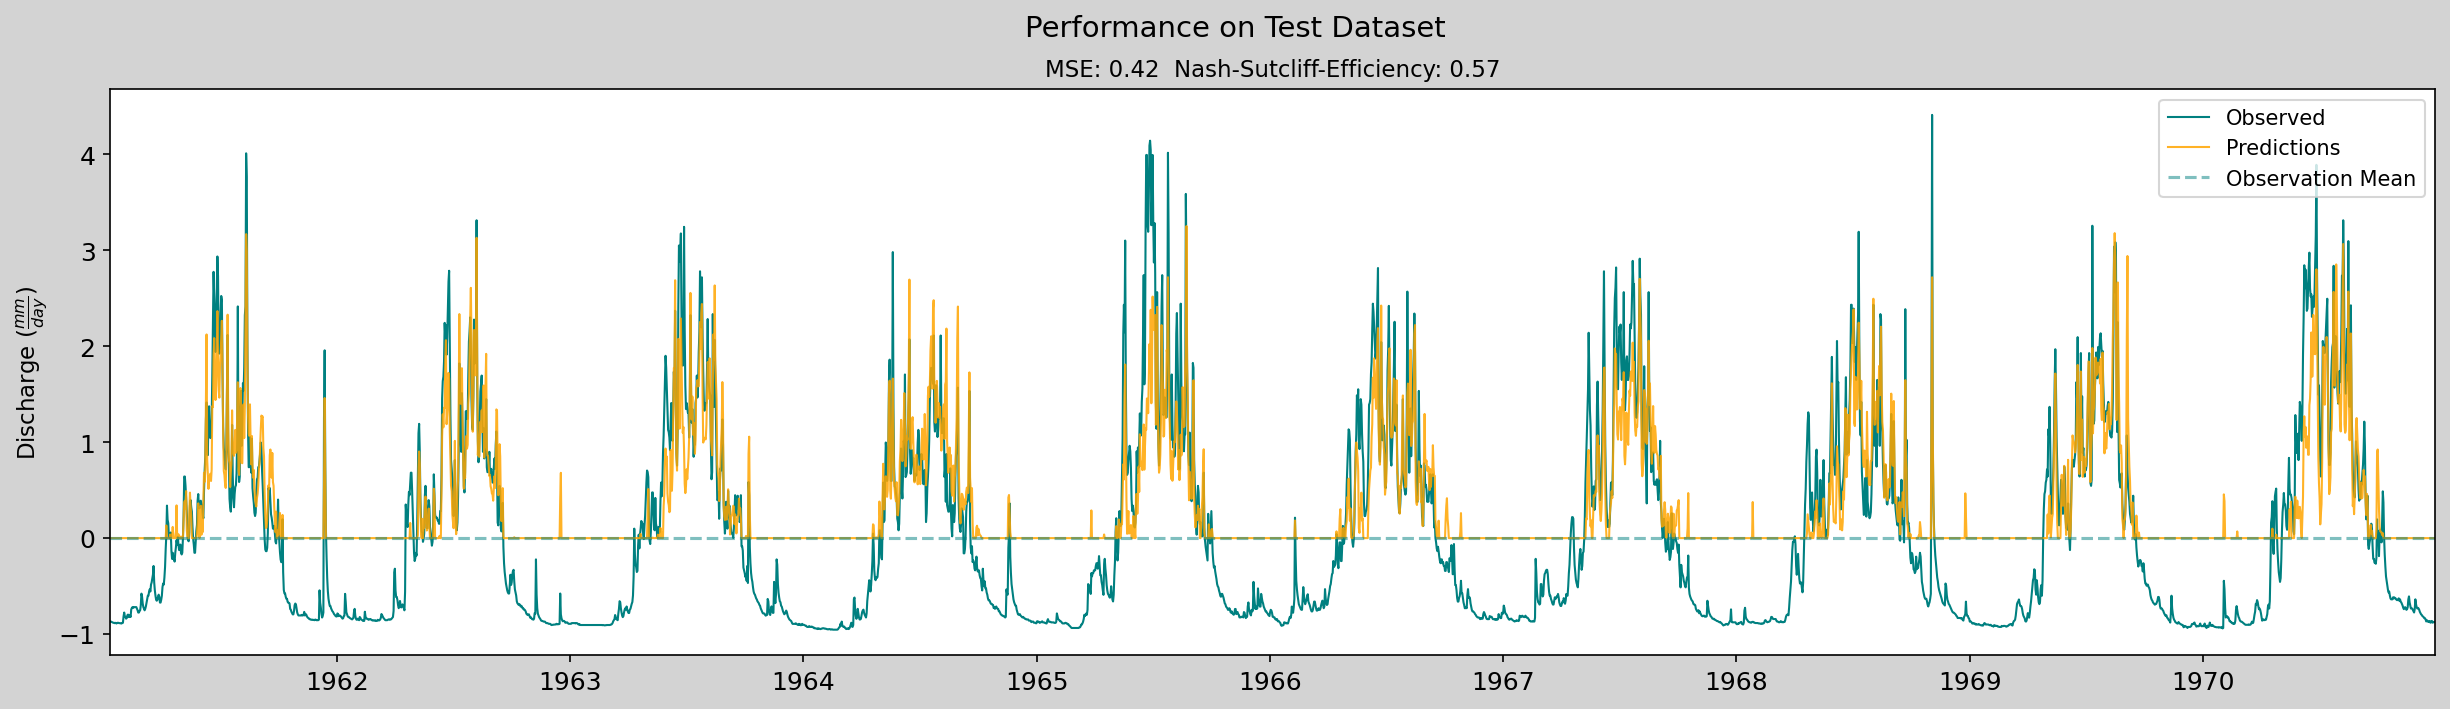

In [142]:
#Plotting out the Predicted Time Series on the Dataset
test_obs_mean = torch.mean(test_ytensor)
with torch.no_grad():
    fig, ax = plt.subplots(figsize = (20,5), dpi=150)
    ax.plot(test_set.index[window_size-1:], 
            test_ytensor.cpu().numpy(),
            c='teal', 
            linewidth=1,
            label='Observed')
    ax.plot(test_set.index[window_size-1:], 
            model(test_Xtensor).cpu().numpy(), 
            c='orange', 
            alpha=0.85, 
            linewidth=1,
            label='Predictions')
    ax.axhline(test_ytensor.mean().item(), color='teal', alpha=0.5, linestyle='--', label='Observation Mean')
    ax.legend()
    mse, NSE = eval_model(model,
                          test_loader,
                          loss_func,
                          calc_nse)
    fig.suptitle('Performance on Test Dataset', size=14)
    fig.set_facecolor('lightgrey')
    ax.set_title(f'MSE: {mse:0.2f}  Nash-Sutcliff-Efficiency: {NSE:0.2f}', size=11)
    ax.set_ylabel('Discharge ($\\frac{mm}{day}$)', size=11)
    ax.autoscale(enable=True, axis='x', tight=True)

Finally, assuming your decisions and ours were the same, evaluating your model with the code above should$^*$ give you the figure below:
<center><img src='https://unils-my.sharepoint.com/:i:/g/personal/tom_beucler_unil_ch/EUEtOgx5IzBJjIFELU3KdvIBDpFB1d_qnNr_HarNvVMGYA?download=1' width=100%>

$_{^{*}\text{Once again, GPU operations are generally non-deterministic - you should get something remarkably similar}}$